In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
# from sklearn.compose import make_column_transformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras.metrics as metrics
from scikeras.wrappers import KerasClassifier
from sklearn.datasets import make_classification
import time
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import (classification_report, confusion_matrix, make_scorer, f1_score, recall_score, balanced_accuracy_score,
matthews_corrcoef, jaccard_score, average_precision_score, roc_auc_score)
from tabulate import tabulate
from sklearn.base import ClassifierMixin, BaseEstimator
import winsound
import random
import os
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils.class_weight import compute_class_weight

In [2]:
X_nt = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_non_test_set.csv", index_col = 0)
X_t = pd.read_csv("C:\Aniruddh\Python\Jupyter\RCC\CSV FILES\Cleaned data\RCC_test_set.csv", index_col = 0)
X_nt = X_nt.drop(index = 83)
X = pd.concat([X_nt, X_t])
y = X.pop("RECURRENCE")
y_nt = X_nt.pop("RECURRENCE")
y_t = X_t.pop("RECURRENCE")

In [3]:
X_nontest = X_nt.copy()
y_nontest = y_nt.copy()
X_test = X_t.copy()
y_test = y_t.copy()

In [4]:
drop_onehot = ['SEX_F', 'SITE_BL', 'HISTOPATHOLOGY_PAP', 'APPROACH_3']
X_nontest = X_nontest.drop(columns = drop_onehot)
X_test = X_test.drop(columns = drop_onehot)

In [5]:
undersampler = RandomUnderSampler(random_state=42)
X_nt_resampled, y_nt_resampled = undersampler.fit_resample(X_nontest, y_nontest)

In [6]:
X_train_und, X_val_und, y_train_und, y_val_und = train_test_split(X_nt_resampled, y_nt_resampled, test_size = 0.3, stratify = y_nt_resampled)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_nontest, y_nontest, test_size = 0.3, stratify = y_nontest)

In [9]:
def preprocessor(X_train, X_test, X_val = None):
    imputer = SimpleImputer(strategy = 'median')
    scaler = StandardScaler()
    X_train_pp = scaler.fit_transform(imputer.fit_transform(X_train))
    X_test_pp = scaler.transform(imputer.transform(X_test))
    if X_val is not None:
        X_val_pp = scaler.transform(imputer.transform(X_val))
        return X_train_pp, X_test_pp, X_val_pp
    else:
        return X_train_pp, X_test_pp

In [10]:
X_train_und_pp, X_test_und_pp, X_val_und_pp = preprocessor(X_train_und, X_test, X_val_und)

In [11]:
X_train_pp, X_test_pp, X_val_pp = preprocessor(X_train, X_test, X_val)

In [13]:
model = Sequential([
    Dense(30, input_shape=(X_train_und.shape[1],), kernel_regularizer=l2(0.01)),
    LeakyReLU(0.2),
    Dropout(0.2),
    Dense(20, kernel_regularizer=l2(0.01)), # activation='elu'), #),
    LeakyReLU(0.2),
    # Dropout(0.3),
    # Dense(100, kernel_regularizer=l2(0.01)), # activation='elu'), #kernel_regularizer=l2(0.01)),
    # LeakyReLU(0.2),
    # Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model.fit(X_train_und_pp, y_train_und, epochs = 600, batch_size = len(X_train_und_pp), validation_data = [X_val_und_pp, y_val_und],
                                callbacks = [early_stopping])

Epoch 1/600
1/1 [==============================] - 4s 4s/step - loss: 1.2752 - accuracy: 0.5412 - val_loss: 1.1991 - val_accuracy: 0.5676
Epoch 2/600
1/1 [==============================] - 0s 81ms/step - loss: 1.2709 - accuracy: 0.5529 - val_loss: 1.1933 - val_accuracy: 0.5946
Epoch 3/600
1/1 [==============================] - 0s 87ms/step - loss: 1.2699 - accuracy: 0.5059 - val_loss: 1.1872 - val_accuracy: 0.5946
Epoch 4/600
1/1 [==============================] - 0s 85ms/step - loss: 1.2196 - accuracy: 0.5529 - val_loss: 1.1813 - val_accuracy: 0.5946
Epoch 5/600
1/1 [==============================] - 0s 79ms/step - loss: 1.2114 - accuracy: 0.5412 - val_loss: 1.1757 - val_accuracy: 0.5676
Epoch 6/600
1/1 [==============================] - 0s 80ms/step - loss: 1.2254 - accuracy: 0.5176 - val_loss: 1.1705 - val_accuracy: 0.5676
Epoch 7/600
1/1 [==============================] - 0s 87ms/step - loss: 1.2210 - accuracy: 0.4824 - val_loss: 1.1657 - val_accuracy: 0.5676
Epoch 8/600
1/1 [=====

In [15]:
scores_df = pd.DataFrame(columns=['Train F1 Score', 'Validation F1 Score', 'Test F1 Score', 'Train AUC-PR', 'Val AUC-PR', 'Test AUC-PR'])
predictions_train = model.predict(X_train_und_pp)
threshold = 0.5  # Adjust the threshold as needed
predicted_labels = (predictions_train > threshold).astype(int)
train_f1_score = f1_score(y_train_und, predicted_labels)
# print("f1 score: ", train_f1_score)
# print(predicted_labels.reshape((-1)))
train_auc_pr = average_precision_score(y_train_und, predicted_labels)
# print("AUC-PR:", train_auc_pr)
cm = confusion_matrix(y_train_und, predicted_labels)
class_names = ['Class 0', 'Class 1']
cm_table_train = tabulate(cm, headers=class_names, tablefmt='grid')
print("Confusion Matrix:")
print(cm_table_train)

predictions_val = model.predict(X_val_und_pp)
predicted_labels = (predictions_val > threshold).astype(int)
val_f1_score = f1_score(y_val_und, predicted_labels)
# print("f1 score: ", val_f1_score)
# print(predicted_labels.reshape((-1)))
val_auc_pr = average_precision_score(y_val_und, predicted_labels)
cm = confusion_matrix(y_val_und, predicted_labels)
cm_table_val = tabulate(cm, headers=class_names, tablefmt='grid')
print("Confusion Matrix:")
print(cm_table_val)

predictions = model.predict(X_test_und_pp)
predicted_labels = (predictions > threshold).astype(int)
test_f1_score = f1_score(y_test, predicted_labels)
print("f1 score: ", test_f1_score)
# print(predicted_labels.reshape((-1)))
test_auc_pr = average_precision_score(y_test, predicted_labels)
cm = confusion_matrix(y_test, predicted_labels)
cm_table_test = tabulate(cm, headers=class_names, tablefmt='grid')
print("Confusion Matrix:")
print(cm_table_test)
scores_df = pd.concat([scores_df, pd.DataFrame({'Train F1 Score': [train_f1_score],
                                                'Validation F1 Score': [val_f1_score],
                                                'Test F1 Score': [test_f1_score],
                                                'Train AUC-PR': [train_auc_pr],
                                                'Val AUC-PR': [val_auc_pr],
                                                'Test AUC-PR': [test_auc_pr]})], ignore_index=True)
display(scores_df)

3/3 [==============================] - 0s 7ms/step
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        33 |         9 |
+-----------+-----------+
|         3 |        40 |
+-----------+-----------+
2/2 [==============================] - 0s 5ms/step
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|        10 |         9 |
+-----------+-----------+
|         4 |        14 |
+-----------+-----------+
7/7 [==============================] - 0s 5ms/step
f1 score:  0.2689075630252101
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       106 |        77 |
+-----------+-----------+
|        10 |        16 |
+-----------+-----------+


C:\Users\aniru\AppData\Local\Temp\ipykernel_28152\2985991068.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame({'Train F1 Score': [train_f1_score],


,Train F1 Score,Validation F1 Score,Test F1 Score,Train AUC-PR,Val AUC-PR,Test AUC-PR
0,0.869565,0.682927,0.268908,0.794668,0.581538,0.15372


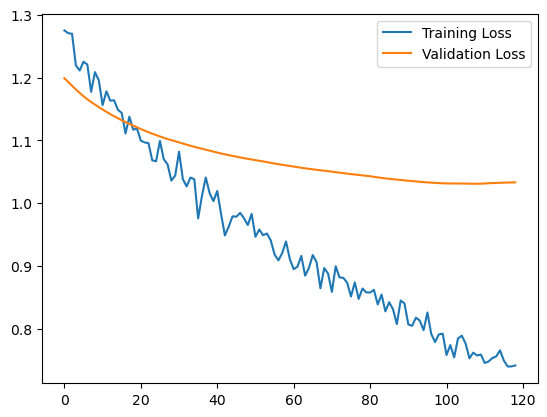

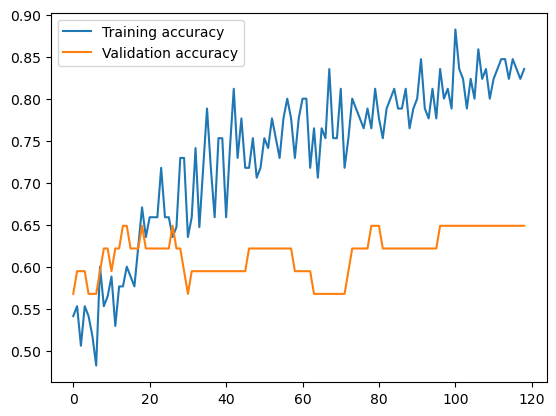

In [16]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(accuracy, label = 'Training accuracy')
plt.plot(val_accuracy, label = 'Validation accuracy')
plt.legend()
plt.show()

In [17]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    """Focal Loss implementation."""
    epsilon = 1e-8
    y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)  # Clip predicted probabilities to prevent NaNs
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))  # Actual probability for the positive class
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))  # Actual probability for the negative class
    loss = -alpha * tf.pow(1.0 - pt_1, gamma) * tf.math.log(pt_1) - (1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1.0 - pt_0)
    return tf.reduce_mean(loss)

In [32]:
model = Sequential([
    Dense(100, kernel_regularizer=l2(0.01), input_shape=(X_train_und.shape[1],)),
    # LeakyReLU(0.2),
    # Dropout(0.2),
    # Dense(20, kernel_regularizer=l2(0.01)), # activation='elu'), #),
    # LeakyReLU(0.2),
    # # Dropout(0.3),
    # # Dense(100, kernel_regularizer=l2(0.01)), # activation='elu'), #kernel_regularizer=l2(0.01)),
    # # LeakyReLU(0.2),
    # # Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))
])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
# model.compile(optimizer=Adam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate = 0.001), loss=tf.keras.losses.BinaryFocalCrossentropy(from_logits=False), metrics=['accuracy'])

In [33]:
history = model.fit(X_train_pp, y_train, epochs = 600, batch_size = 17, validation_data = [X_val_pp, y_val],
                                callbacks = [early_stopping])

Epoch 1/600
20/20 [==============================] - 3s 37ms/step - loss: 0.5887 - accuracy: 0.5947 - val_loss: 0.5026 - val_accuracy: 0.7671
Epoch 2/600
20/20 [==============================] - 0s 9ms/step - loss: 0.4781 - accuracy: 0.8195 - val_loss: 0.4533 - val_accuracy: 0.8425
Epoch 3/600
20/20 [==============================] - 0s 9ms/step - loss: 0.4246 - accuracy: 0.8669 - val_loss: 0.4109 - val_accuracy: 0.8562
Epoch 4/600
20/20 [==============================] - 0s 9ms/step - loss: 0.3886 - accuracy: 0.8609 - val_loss: 0.3770 - val_accuracy: 0.8767
Epoch 5/600
20/20 [==============================] - 0s 9ms/step - loss: 0.3570 - accuracy: 0.8698 - val_loss: 0.3490 - val_accuracy: 0.8699
Epoch 6/600
20/20 [==============================] - 0s 9ms/step - loss: 0.3316 - accuracy: 0.8669 - val_loss: 0.3225 - val_accuracy: 0.8767
Epoch 7/600
20/20 [==============================] - 0s 9ms/step - loss: 0.3059 - accuracy: 0.8698 - val_loss: 0.3023 - val_accuracy: 0.8699
Epoch 8/600


In [34]:
scores_df = pd.DataFrame(columns=['Train F1 Score', 'Validation F1 Score', 'Test F1 Score', 'Train AUC-PR', 'Val AUC-PR', 'Test AUC-PR'])
predictions_train = model.predict(X_train_pp)
threshold = 0.5  # Adjust the threshold as needed
predicted_labels = (predictions_train > threshold).astype(int)
train_f1_score = f1_score(y_train, predicted_labels)
# print("f1 score: ", train_f1_score)
# print(predicted_labels.reshape((-1)))
train_auc_pr = average_precision_score(y_train, predicted_labels)
# print("AUC-PR:", train_auc_pr)
cm = confusion_matrix(y_train, predicted_labels)
class_names = ['Class 0', 'Class 1']
cm_table_train = tabulate(cm, headers=class_names, tablefmt='grid')
print("Confusion Matrix:")
print(cm_table_train)

predictions_val = model.predict(X_val_pp)
predicted_labels = (predictions_val > threshold).astype(int)
val_f1_score = f1_score(y_val, predicted_labels)
# print("f1 score: ", val_f1_score)
# print(predicted_labels.reshape((-1)))
val_auc_pr = average_precision_score(y_val, predicted_labels)
cm = confusion_matrix(y_val, predicted_labels)
cm_table_val = tabulate(cm, headers=class_names, tablefmt='grid')
print("Confusion Matrix:")
print(cm_table_val)

predictions = model.predict(X_test_pp)
predicted_labels = (predictions > threshold).astype(int)
test_f1_score = f1_score(y_test, predicted_labels)
print("f1 score: ", test_f1_score)
# print(predicted_labels.reshape((-1)))
test_auc_pr = average_precision_score(y_test, predicted_labels)
cm = confusion_matrix(y_test, predicted_labels)
cm_table_test = tabulate(cm, headers=class_names, tablefmt='grid')
print("Confusion Matrix:")
print(cm_table_test)
scores_df = pd.concat([scores_df, pd.DataFrame({'Train F1 Score': [train_f1_score],
                                                'Validation F1 Score': [val_f1_score],
                                                'Test F1 Score': [test_f1_score],
                                                'Train AUC-PR': [train_auc_pr],
                                                'Val AUC-PR': [val_auc_pr],
                                                'Test AUC-PR': [test_auc_pr]})], ignore_index=True)
display(scores_df)

11/11 [==============================] - 0s 3ms/step
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       293 |         2 |
+-----------+-----------+
|        42 |         1 |
+-----------+-----------+
5/5 [==============================] - 0s 4ms/step
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       128 |         0 |
+-----------+-----------+
|        18 |         0 |
+-----------+-----------+
7/7 [==============================] - 0s 4ms/step
f1 score:  0.0
Confusion Matrix:
+-----------+-----------+
|   Class 0 |   Class 1 |
+===========+===========+
|       183 |         0 |
+-----------+-----------+
|        26 |         0 |
+-----------+-----------+


C:\Users\aniru\AppData\Local\Temp\ipykernel_28152\3752412812.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame({'Train F1 Score': [train_f1_score],


,Train F1 Score,Validation F1 Score,Test F1 Score,Train AUC-PR,Val AUC-PR,Test AUC-PR
0,0.043478,0.0,0.0,0.132012,0.123288,0.124402


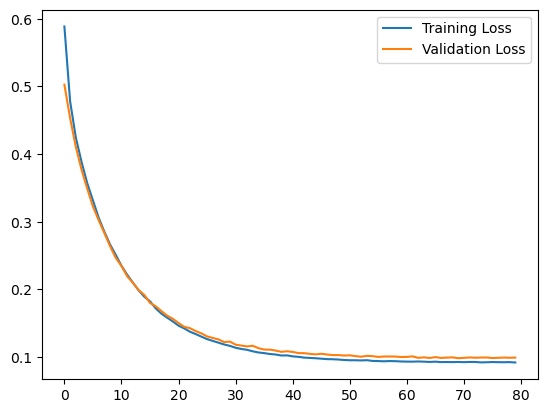

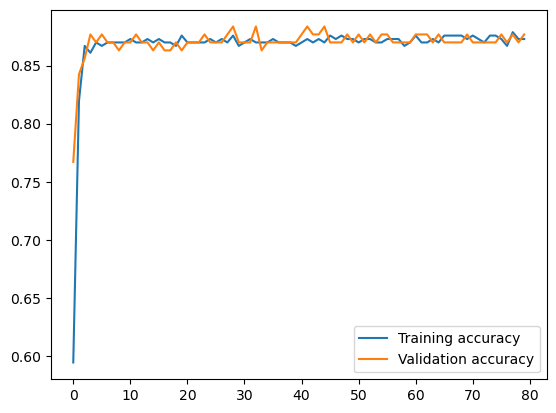

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.legend()
plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(accuracy, label = 'Training accuracy')
plt.plot(val_accuracy, label = 'Validation accuracy')
plt.legend()
plt.show()